# Combining Processed Crop Data
This notebook combines the processed crop data at the country level into a single data file.

In [1]:
import os, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf
from tools import CreateLinkAdmin
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

## Combine the processed crop data and shapefile

In [2]:
# Merge crop data
countries_ISO = [
    'AF','AO','BF','GN','KE','LR',
    'LS','MG','ML','MW','NE','SN',
    'SO','TD','YE','ZA','ZM'
]
container = []
for name in countries_ISO:
    df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % name)
    # Select the calibrated data
    df = df[df['gscd_code'] == 'calibrated']
    # if name == 'KE':
    #     # Manual editing -------------------------- #
    #     # - Fill missing "Long" and "short" season records with "Annual" records for Kenya
    #     df_raw = df.copy()
    #     cols = [
    #         'fnid', 'country', 'country_code', 'admin_1', 'admin_2',
    #         'product', 'season_name', 'planting_month', 'harvest_month', 
    #         'crop_production_system', 'indicator'
    #     ]
    #     df['year'] = df['harvest_year']
    #     df = df.pivot_table(index='year', columns=cols, values='value')
    #     annual = df.loc[:,pd.IndexSlice[:,'Kenya',:,:,:,'Maize','Annual',:]]
    #     annual.columns = annual.columns.droplevel([1,2,3,4,5,6,7,8,9])
    #     long = df.loc[:,pd.IndexSlice[:,'Kenya',:,:,:,'Maize','Long',:]]
    #     long.columns = long.columns.droplevel([1,2,3,4,5,6,7,8,9])
    #     long = long.fillna(annual)
    #     df.loc[:,pd.IndexSlice[:,'Kenya',:,:,:,'Maize','Long',:]] = long.values
    #     short = df.loc[:,pd.IndexSlice[:,'Kenya',:,:,:,'Maize','Short',:]]
    #     short.columns = short.columns.droplevel([1,2,3,4,5,6,7,8,9])
    #     short = short.fillna(annual)
    #     df.loc[:,pd.IndexSlice[:,'Kenya',:,:,:,'Maize','Short',:]] = short.values
    #     df = df.T.stack(dropna=True).reset_index().rename(columns={0:'value'})
    #     # Restore columns such as planting year
    #     df = df.rename(columns={'year':'harvest_year'})
    #     df['gscd_code'] = 'calibrated'
    #     df['name'] = df['admin_1']
    #     df['planting_year'] = df['harvest_year']
    #     df.loc[df['season_name'] == 'Short', 'planting_year'] -= 1
    #     df = df[df_raw.columns]
    #     # ----------------------------------------- #
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)

# Merge the latest shapefile
container = []
path_dir = './data/shapefile/fewsnet/'
container.append(gpd.read_file(os.path.join(path_dir, 'AF_Admin1_2017.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'AO_Admin1_2008.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'BF_Admin2_2001.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'GN_Admin2_1990.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'KE_Admin1_2013.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'LR_Admin1_2008.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'LS_Admin1_1980.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'MG_Admin2_2009.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'ML_Admin1_2016.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'MW_Admin2_2003.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'NE_Admin2_2012.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'SN_Admin2_2008.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'SO_Admin2_1990.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'TD_Admin1_2012.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'YE_Admin1_2014.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'ZA_Admin1_1994.shp')))
container.append(gpd.read_file(os.path.join(path_dir, 'ZM_Admin2_2011.shp')))
shape = pd.concat(container, axis=0).reset_index(drop=True)[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.to_crs(epsg=4326)

# Unstable version (internal research purpose) -------------- #
save_hdf('./data/crop/adm_crop_production_ALL.hdf', df)
fn_out = './data/crop/adm_crop_production_ALL.csv'
df.to_csv(fn_out); print('%s is saved.' % fn_out)
fn_out = './data/shapefile/adm_shapefile.shp'
shape.to_file(fn_out); print('%s is saved.' % fn_out)
shape_simplified = shape.copy()
shape_simplified.geometry = shape_simplified.geometry.simplify(0.001)
fn_out = './data/shapefile/adm_shapefile.json'
geojson = json.loads(shape_simplified.to_json())
with open(fn_out,'w') as f:
    f.write(json.dumps(geojson)); print(f'{fn_out} is saved.')
# ----------------------------------------------------------- #

# # Stable version (public sharing) --------------------------- #
# # stable_country_list = ['Burkina Faso', 'Kenya', 'Somalia', 'Malawi']
# stable_country_list = df['country'].unique()
# stable_data = df[df['country'].isin(stable_country_list)].reset_index(drop=True)
# stable_shape = shape_simplified[shape_simplified['ADMIN0'].isin(stable_country_list)].reset_index(drop=True)
# fn_out = './public/gscd_data.csv'
# stable_data.to_csv(fn_out); print('%s is saved.' % fn_out)
# fn_out = './public/gscd_shape.shp'
# stable_shape.to_file(fn_out); print('%s is saved.' % fn_out)
# fn_out = './public/gscd_shape.json'
# geojson = json.loads(stable_shape.to_json())
# with open(fn_out,'w') as f:
#     f.write(json.dumps(geojson)); print(f'{fn_out} is saved.')
# # ----------------------------------------------------------- #

./data/crop/adm_crop_production_ALL.hdf is saved.
./data/crop/adm_crop_production_ALL.csv is saved.
./data/shapefile/adm_shapefile.shp is saved.
./data/shapefile/adm_shapefile.json is saved.


## Summary of "adm_crop_production_ALL.hdf"

In [3]:
shape = gpd.read_file('./data/shapefile/adm_shapefile.shp')
df = pd.read_hdf('./data/crop/adm_crop_production_ALL.hdf')
df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
df = df[['fnid','country','admin1','admin2','product','season','harvest_month','harvest_year','indicator','value']]
cps = df[['country','product','season']].drop_duplicates().reset_index(drop=True)
df['admin'] = df['fnid'].apply(lambda x: x[2:8])
table = pd.DataFrame(
    index=pd.MultiIndex.from_frame(df[['country','admin','season']].drop_duplicates()),
    columns= cps['product'].unique(),
    data = '-'
).rename_axis(columns='product')
for i, (country_name, product_name, season_name) in cps.iterrows():
    fnids_country = shape.loc[shape['ADMIN0'] == country_name, 'FNID']
    sub = df[
        (df['country'] == country_name) &
        (df['product'] == product_name) &
        (df['season'] == season_name) &
        (df['indicator'] == 'production')
    ]
    if sub.shape[0] > 0:
        count = sub.pivot_table(index='harvest_year', columns='fnid', values='value', aggfunc='count', fill_value=0)
        mean_count = count.sum().mean()
        string = '%d (%d/%d)' %  (mean_count, count.shape[1], len(fnids_country))
    else:
        string = '-'
    table.loc[pd.IndexSlice[country_name,:,season_name],product_name] = string
print('Mean record years (recorded districts / total districts)')
table

Mean record years (recorded districts / total districts)


product                               Wheat       Maize     Sorghum  \
country      admin  season                                            
Afghanistan  2017A1 Spring       18 (33/34)           -           -   
                    Winter       18 (33/34)           -           -   
Angola       2008A1 Main           1 (2/18)  26 (18/18)   7 (16/18)   
Burkina Faso 2001A2 Main                  -  34 (45/45)  34 (45/45)   
Guinea       1990A2 Main                  -   8 (31/34)           -   
Kenya        2013A1 Annual       23 (21/47)  21 (46/47)   6 (46/47)   
                    Long                  -  12 (47/47)   1 (44/47)   
                    Short                 -   7 (45/47)   2 (35/47)   
Liberia      2008A1 Main                  -           -           -   
Lesotho      1980A1 Summer       33 (10/10)  37 (10/10)  36 (10/10)   
                    Winter         6 (6/10)           -           -   
Madagascar   2009A2 Annual                -  30 (22/22)           -   
Mali         2016A1 Main          18 (3/11)   29 (7/11)   37 (7/11)   
Malawi       2003A2 Main          5 (16/28)  38 (28/28)  22 (26/28)   
                    Winter         2 (7/28)  11 (28/28)           -   
Niger        2012A2 Main season           -  13 (42/74)  36 (69/74)   
Senegal      2008A2 Main season           -  35 (41/45)  25 (42/45)   
                    Off season            -    6 (2/45)           -   
Somalia      1990A2 Gu                    -  24 (38/74)  18 (40/74)   
                    Deyr                  -  21 (38/74)  17 (43/74)   
                    Gu-off                -   5 (26/74)    2 (3/74)   
                    Deyr-off              -   4 (27/74)    1 (2/74)   
Chad         2012A1 Main          28 (1/23)  25 (17/23)  29 (17/23)   
                    Cold-off              -           -  19 (17/23)   
Yemen        2014A1 Annual       19 (20/22)  20 (21/22)  22 (21/22)   
South Africa 1994A1 Winter         39 (9/9)           -           -   
                    Summer         16 (9/9)           -    24 (9/9)   
Zambia       2011A2 Annual        6 (34/74)  33 (71/74)  18 (71/74)   

product                              Millet        Rice       Fonio  \
country      admin  season                                            
Afghanistan  2017A1 Spring                -           -           -   
                    Winter                -           -           -   
Angola       2008A1 Main         10 (15/18)  11 (10/18)           -   
Burkina Faso 2001A2 Main         34 (45/45)  33 (45/45)  19 (17/45)   
Guinea       1990A2 Main                  -   8 (33/34)   2 (33/34)   
Kenya        2013A1 Annual        6 (41/47)   2 (23/47)           -   
                    Long                  -           -           -   
                    Short                 -           -           -   
Liberia      2008A1 Main                  -  10 (15/15)           -   
Lesotho      1980A1 Summer                -           -           -   
                    Winter                -           -           -   
Madagascar   2009A2 Annual                -  31 (22/22)           -   
Mali         2016A1 Main          37 (7/11)   36 (7/11)   36 (5/11)   
Malawi       2003A2 Main         21 (26/28)  21 (28/28)           -   
                    Winter         1 (2/28)  10 (10/28)           -   
Niger        2012A2 Main season  37 (71/74)  16 (21/74)    9 (9/74)   
Senegal      2008A2 Main season  47 (42/45)  34 (36/45)   6 (10/45)   
                    Off season            -    8 (2/45)           -   
Somalia      1990A2 Gu                    -   11 (1/74)           -   
                    Deyr                  -    5 (2/74)           -   
                    Gu-off                -           -           -   
                    Deyr-off              -           -           -   
Chad         2012A1 Main         31 (18/23)  21 (16/23)    4 (7/23)   
                    Cold-off              -           -           -   
Yemen        2014A1 Ann

## Map of processed countries

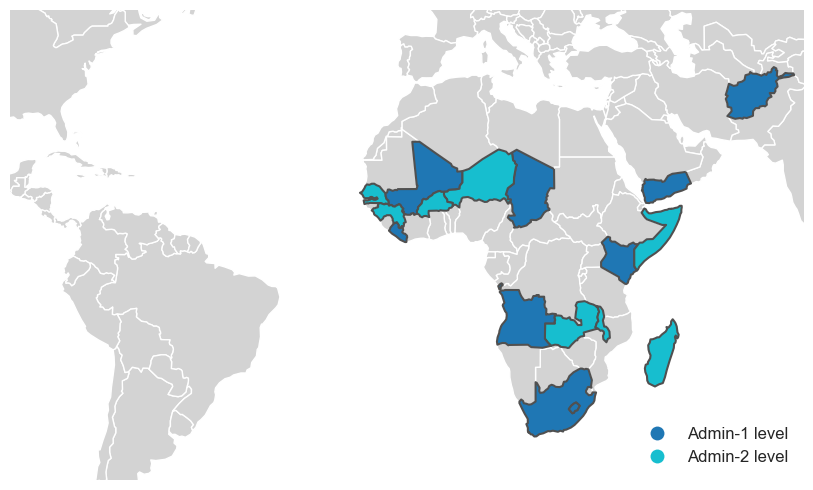

In [4]:
# Little touch on world boundary ---------------------------- #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
somalia = world[world['name'].isin(['Somalia', 'Somaliland'])].dissolve()
world = pd.concat([world[~world['name'].isin(['Somalia', 'Somaliland'])], somalia], axis=0)
df = pd.read_hdf('./data/crop/adm_crop_production_ALL.hdf')
# ----------------------------------------------------------- #
df['admin'] = df['fnid'].apply(lambda x: x[7])
country_processed = df[['country','admin']].drop_duplicates()
map_processed = world.merge(country_processed, left_on='name', right_on='country', how='inner')
assert len(map_processed['country'].dropna().unique()) == len(df['country'].unique())
map_processed['admin'] = map_processed['admin'].replace({'1':'Admin-1 level', '2':'Admin-2 level'})

# Plotting
mapdata = map_processed.copy().to_crs('epsg:3857')
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis([-10287412, 8589989, -5174166, 6005999])
world.to_crs('epsg:3857').plot(ax=ax, color='lightgrey')
mapdata.plot(ax=ax, column='admin',linewidth=1.5, edgecolor='#505050', zorder=2,
            categorical=True, legend=True,
            legend_kwds={'loc': 'lower right', 'bbox_to_anchor':(1,0), 'frameon':False, 'fontsize':12},
)
plt.tight_layout()
fig.savefig('./docs/current_status_map.svg',pad_inches=0, bbox_inches='tight', transparent=False)

## (untracked) Somalia - Gu (table format)

In [ ]:
# for product_name in ['Maize', 'Sorghum']:
#     df = pd.read_hdf('./data/crop/adm_crop_production_ALL.hdf')
#     df = df[
#         (df['country'] == 'Somalia') &
#         (df['product'] == product_name) &
#         (df['season_name'] == 'Gu')
#     ].reset_index(drop=True)
#     df = df.pivot_table(index='fnid',columns=['indicator','year'],values='value')
#     with pd.ExcelWriter('./public/somalia/adm_crop_production_table_somalia_gu_%s.xlsx' % product_name.lower()) as writer:  
#         df['production'].to_excel(writer, sheet_name='quantity_produced')
#         df['area'].to_excel(writer, sheet_name='harvested_area')
#         df['yield'].to_excel(writer, sheet_name='yield')

## (untracked) Export to public data folder

In [ ]:
# # Weston's Google Drive
# shape = gpd.read_file('./data/shapefile/adm_current.shp')
# df = pd.read_hdf('./data/crop/adm_crop_production_ALL.hdf')
# df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
# df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
# df = df[['fnid','country','admin1','admin2','product','season','harvest_end','year','indicator','value']]
# df = df[
#     (df['season'].isin(['Gu','Deyr','Long','Short','Main'])) &
#     (df['product'].isin(['Maize','Wheat','Sorghum']))
# ].reset_index(drop=True)
# cps = df[['country','product','season']].drop_duplicates()
# print(cps)
# df_yield = df[df['indicator'] == 'yield']
# df_yield = df_yield.pivot_table(index=['fnid','country','admin1','admin2','product','season','harvest_end','indicator'], columns='year', values='value')
# df_yield = df_yield.astype(np.float32).round(3)
# fn_out = './public/grain_yield_africa.csv'
# df_yield.to_csv(fn_out)
# print("%s is saved." % fn_out)
# fn_out = './public/grain_pay_africa.csv'
# df.to_csv(fn_out)
# print("%s is saved." % fn_out)
# shape.to_file('./public/admin_africa.shp')
# print('./public/admin_africa.shp is saved.')

## (Untrackted) Binary availabililty table

In [ ]:
# sub = df[df['indicator'] == 'production']
# table = sub.pivot_table(index=['country','season_name','product','planting_month','harvest_month','fnid'],columns='harvest_year',values='value',aggfunc='count')
# table[table.isna()] = 0
# table[table > 0] = 1
# table = table.astype(np.int)
# table.to_csv('./data/crop/binary_availability.csv')